In [48]:
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch import nn

from torchvision import transforms, models
from XrayDataset import XrayDataset
from torch.utils.data import DataLoader
import itertools
from utils import plot_confusion_matrix



Bad key "text.kerning_factor" on line 4 in
/home/ramkik/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [10]:
checkpoint_path = 'ckpt-299.pth.tar'

In [5]:
model = models.resnet50(pretrained=True)


In [8]:
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 3))

In [11]:
checkpoint  = torch.load(checkpoint_path)

In [12]:
distributed_state_dict = checkpoint['state_dict']

In [14]:
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in distributed_state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

In [15]:
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [30]:
model = model.cuda()

In [32]:
criterion = nn.CrossEntropyLoss()


In [25]:
batch_size = 4

In [26]:
test_transforms = transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5], std=[0.5])
                                      ])

In [27]:
train_dataset = XrayDataset( 'data', 'train', 'train.csv', test_transforms )

dataloader = DataLoader(train_dataset, batch_size=batch_size,  shuffle=True, num_workers=4)


In [39]:
model.eval()


correct = 0
total = 0
running_loss = 0.0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for i, (input, target) in enumerate(dataloader):
        target = target.cuda()

        # compute output
        output = model(input.cuda())
        loss = criterion(output, target)
        _, predicted = torch.max(output.data, 1)
        predicted_labels.append(predicted.tolist())
        true_labels.append(target.tolist())
        #print(torch.squeeze(predicted), "--->", target )
        total += target.size(0)
        correct += (predicted == target).sum().item()

        running_loss += loss.item()

predicted_labels = list(itertools.chain(*predicted_labels))
true_labels = list(itertools.chain(*true_labels))

accurecy = 100 * correct / total


[0, 2, 1, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2, 1, 0, 1, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 1, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 1, 1, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 1, 2, 2, 2, 2, 0, 2, 0, 2, 1, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 1, 2, 0, 0, 1, 2, 0, 2, 0, 2, 0, 1, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 2, 2, 1, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 1, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 1, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 2, 2, 2, 1, 2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 

In [41]:
classes = ['normal', 'COVID-19', 'other_pneumonia']

In [44]:
class_dict ={classes[i]: i for i in range(3)}

In [46]:
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion matrix")
print(cm)

Confusion matrix
[[407   1   0]
 [ 18  89   7]
 [ 12   0 411]]


In [47]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       408
           1       0.99      0.78      0.87       114
           2       0.98      0.97      0.98       423

    accuracy                           0.96       945
   macro avg       0.97      0.92      0.94       945
weighted avg       0.96      0.96      0.96       945



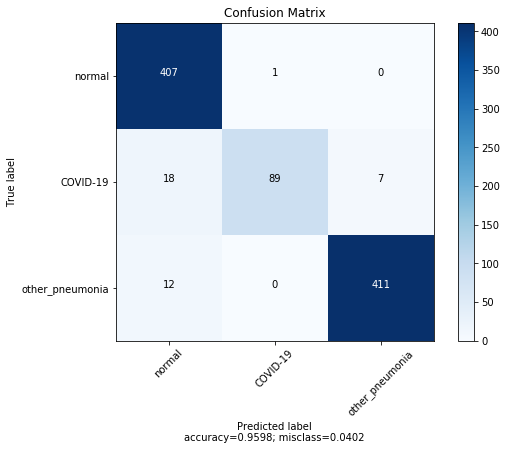

In [49]:
plot_confusion_matrix(cm, normalize    = False,
                      target_names = classes,
                      title        = "Confusion Matrix")